In [2]:
import xarray as xr
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import pandas as pn
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import timeit
import gsw
import matplotlib.patches as mpatches
from scipy import interpolate
import timeit

## Load the ARGO data using Opendap from the Asia Pacific Data Research Center

In [3]:
# Import the gridded argo data as a xarray datset
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Argo_Products/monthly_mean/Gridded_monthly_mean'
argo = xr.open_dataset(url,decode_times = False)

In [4]:
# Look at the dataset
argo

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 27, lon: 360, time: 180)
Coordinates:
  * time     (time) float64 7.32e+05 7.32e+05 7.32e+05 ... 7.374e+05 7.374e+05
  * lev      (lev) float64 0.0 5.0 10.0 20.0 ... 1.4e+03 1.5e+03 1.75e+03 2e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    temp     (time, lev, lat, lon) float32 ...
    salt     (time, lev, lat, lon) float32 ...
    ptemp    (time, lev, lat, lon) float32 ...
    pden     (time, lev, lat, lon) float32 ...
    addep    (time, lev, lat, lon) float32 ...
    spice    (time, lev, lat, lon) float32 ...
Attributes:
    title:          1x1 gridded Monthly mean on Standard Levels (from 2005)
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/projects/Argo/index.html
    history:        Fri Jul 19 13:26:16 HST 2019 : imported by GrADS Data S

### Make a subset of data within the southern Indian Ocean

Create a subset of the upper 1000m within the box 40.5S to 0.5N and 40.5E to 130.5E

In [5]:
argo_t = argo['ptemp'].sel(lev=slice(0,1000),lat=slice(-40.5,0.5),lon=slice(40.5,130.5))
argo_s = argo['salt'].sel(lev=slice(0,1000),lat=slice(-40.5,0.5),lon=slice(40.5,130.5))
argo_rho = argo['pden'].sel(lev=slice(0,1000),lat=slice(-40.5,0.5),lon=slice(40.5,130.5))

In [6]:
argo_t

<xarray.DataArray 'ptemp' (time: 180, lev: 20, lat: 42, lon: 91)>
[13759200 values with dtype=float32]
Coordinates:
  * time     (time) float64 7.32e+05 7.32e+05 7.32e+05 ... 7.374e+05 7.374e+05
  * lev      (lev) float64 0.0 5.0 10.0 20.0 30.0 ... 700.0 800.0 900.0 1e+03
  * lat      (lat) float64 -40.5 -39.5 -38.5 -37.5 -36.5 ... -2.5 -1.5 -0.5 0.5
  * lon      (lon) float64 40.5 41.5 42.5 43.5 44.5 ... 127.5 128.5 129.5 130.5
Attributes:
    long_name:  argo potential temperature (degc) 

All gridpoints where isopyncal/isotherm of interest (1024kg/m3, 20C) has outcropped are converted to NaN

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


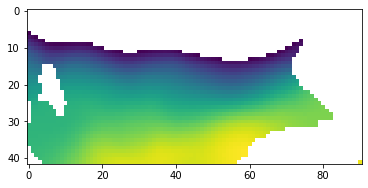

In [4]:
# THIS TAKES A REALLY LONG TIME, DASK FOR THIS TOO? Or some way to mask, instead?
a = argo_rho.where(argo_rho.min(axis=1)<24)
b = argo_s.where(argo_rho.min(axis=1)<24) 
c = argo_t.where(argo_t.max(axis=1)>20)
plt.imshow(c[5,0,:,:])

In [ ]:
#argo_rho[0,:,37,16]

In [ ]:
## Interpolate Salinity to 1024 isopycnal and depth of 20C

In [ ]:
%%time
s24 = np.empty([42,91,168])
xnew = 24
#start = timer()
for i in range(168):
    for j in range(42):
        for k in range(91):
            x = a[i,:,j,k]
            y = b[i,:,j,k]
            f = interpolate.interp1d(x,y,'linear')
            s24[j,k,i] = f(xnew)
    #end = timer()
    #print (end - start)

In [ ]:
d20 = np.empty([42,91,168])
xnew = 20
start = timer()
for i in range(168):
    for j in range(42):
        for k in range(91):
            x = c[i,:,j,k]
            y = argo_t['lev']
            f = interpolate.interp1d(x,y,'linear')
            d20[j,k,i] = f(xnew)
    end = timer()
    print (end - start)

In [ ]:
argo['lev'][0:20]

In [22]:
test = dsa.from_array(a,chunks = 50)

In [23]:
test

dask.array<array, shape=(180, 20, 42, 91), dtype=float32, chunksize=(50, 20, 42, 50)>

In [5]:
import dask as da
import dask.array as dsa

In [6]:
from dask.distributed import Client, LocalCluster, progress
cluster = LocalCluster(n_workers=10)#, threads_per_worker=8, pi='*')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:36963 Dashboard: /user/0000-0001-5324-8593/proxy/8787/status,Cluster Workers: 10 Cores: 20 Memory: 109.84 GB


In [ ]:
%%time
d_iso24 = np.empty([42,91,168])
xnew = 24
#start = timer()
for i in range(168):
    for j in range(42):
        for k in range(91):
            x = test[i,:,j,k]
            y = argo['lev'][0:20]
            f = interpolate.interp1d(x,y,'linear')
            d_iso24[j,k,i] = f(xnew)
    #end = timer()
    #print (end - start)

In [ ]:
%%time
d_iso24 = np.empty([42,91,168])
xnew = 24
#start = timer()
for i in range(1):
    for j in range(42):
        for k in range(91):
            x = test[i,:,j,k]
            y = argo['lev'][0:20]
            f = interpolate.interp1d(x,y,'linear')
            d_iso24[j,k,i] = f(xnew)
    #end = timer()
    #print (end - start)

In [1]:
test

NameError: name 'test' is not defined

In [ ]:
#plt.imshow(d_iso24[:, :, 50].T)
plt.contour(argo_t.lon, argo_t.lat, d_iso24[:, :, 50], colors='k')
plt.contourf(argo_t.lon, argo_t.lat, d_iso24[:, :, 50])
plt.colorbar()

In [ ]:
plt.imshow(s24[:,:,25],cmap = 'coolwarm')

In [ ]:
salt24 = xr.Dataset(data_vars = {'salt':(['LATITUDE','LONGITUDE','TIME'],s24)},
                    coords = {'LATITUDE':a['LATITUDE'],
                              'LONGITUDE':a['LONGITUDE'],
                              'TIME':pn.date_range(start='1/1/2005', end='12/1/2018', freq='MS')})
salt24.to_netcdf('argo_salinity_24sig')

In [ ]:
d20 = xr.Dataset(data_vars = {'depth':(['LATITUDE','LONGITUDE','TIME'],d20)},
                    coords = {'LATITUDE':a['LATITUDE'],
                              'LONGITUDE':a['LONGITUDE'],
                              'TIME':pn.date_range(start='1/1/2005', end='12/1/2018', freq='MS')})
d20.to_netcdf('argo_depth_of_20C')

In [ ]:
i=0
j=7
from timeit import default_timer as timer
start = timer()
for k in range(91):
    x = argo_rho['PDEN'][i,:,j,k]
    if min(x) > 24:
        continue
    else:
        y = argo_s['SALT'][i,:,j,k]
        f = interpolate.interp1d(x,y,'linear')
        s24[j,k,i] = f(xnew)
        
end = timer()
print (end - start)

In [ ]:
argo_t

In [ ]:
argo_rho['PDEN'][0,:,:,:].min(axis = 0)

In [ ]:
argo_rho

In [ ]:
if min(x) > 24:
    print('yes')

In [ ]:
test_s = argo_s[40,:,30,60]
test_rho = argo_rho[40,:,30,60]

In [ ]:
from scipy import interpolate
x = test_rho
y = test_s
f = interpolate.interp1d(x, y,'linear')
f2 = interpolate.interp1d(x,y, 'cubic')
f3 = interpolate.interp1d(x,y, 'nearest')

In [ ]:
xnew = [24]
ynew = f(xnew)   # use interpolation function returned by `interp1d`
ynew2 = f2(xnew)
ynew3 = f3(xnew)
plt.plot(x, y, '-', xnew, ynew, '.',xnew,ynew2,'.',xnew,ynew3,'.')
plt.show()

In [ ]:
ynew

In [ ]:
ynew2

In [ ]:
ynew3

In [ ]:
salt24['LATITUDE'][25:36] #-15.5 to -5.5
salt24['LONGITUDE'][10:81] #50.5E to 120.5E
salt24

In [ ]:
# record the minimum salinity value at each longitude and its latitude (and depth later) monthly

MINS = np.empty([11,71,168])
LOCS = np.empty([11,71,168])
for i in range(168):
    k=0
    for j in range(10,81):
        minimum = ((salt24['salt'][25:36,j,i]*10).round()/10).min()
        locations = np.where((salt24['salt'][25:36,j,i]*10).round()/10==((salt24['salt'][25:36,j,i]*10).round()/10).min())
        MINS[locations,k,i]=minimum
        k=k+1

In [ ]:
plt.imshow(MINS[:,:,10])

In [ ]:
MINS_h = np.empty([11,71,168])
LOCS = np.empty([11,71,168])
for i in range(168):
    k=0
    for j in range(10,81):
        minimum = ((salt24['salt'][25:36,j,i]*100).round()/100).min()
        locations = np.where((salt24['salt'][25:36,j,i]*100).round()/100==((salt24['salt'][25:36,j,i]*100).round()/100).min())
        MINS_h[locations,k,i]=minimum
        k=k+1

In [ ]:
plt.imshow(MINS_h[:,:,10])

In [ ]:
MINS_h[np.where(MINS_h<10)]=np.nan
plt.imshow(MINS_h[:,:,10])

In [ ]:
MINS_L_hov=np.empty([12,71,168])
for k in range(168):
    for j in range(71):
        for i in range(11):
            if MINS_h[i,j,k]>10:
                MINS_L_hov[i,j,k]=salt24['LATITUDE'][i+25]

In [ ]:
MINS_L_hov[np.where(MINS_L_hov>-2)]=np.nan
plt.imshow(MINS_L_hov[:,:,10])

In [ ]:
MINS_L_hovm = np.nanmean(MINS_L_hov,axis=0)
np.shape(MINS_L_hovm)

In [ ]:
MINS_h_hov=np.empty([12,71,168])
for k in range(168):
    for j in range(71):
        for i in range(11):
            if MINS_h[i,j,k]>10:
                MINS_h_hov[i,j,k]=salt24['salt'][i+25,j+10,k]
                MINS_h_hov[i-1,j,k]=salt24['salt'][i-1+25,j+10,k]
                MINS_h_hov[i+1,j,k]=salt24['salt'][i+1+25,j+10,k]

In [ ]:
MINS_h_hov[np.where(MINS_h_hov<10)]=np.nan
plt.imshow(MINS_h_hov[:,:,10])
MINS_h[:,60,10]
#SOMETIMES it is only 2 boxes instead of 3 because there is LAND (nan) on the other side of the min box

In [ ]:
MINS_h_hovm = np.nanmean(MINS_h_hov,axis=0)
np.shape(MINS_h_hovm)

In [ ]:
plt.imshow(MINS_h_hovm)

In [ ]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [ ]:
a=(pn.date_range(start='1/1/2005', end='12/1/2018', freq='MS'))
c=[]
for x in a:
    b=toYearFraction(x)
    c=np.append(c,b)
len(c)

In [ ]:
fig5, ax5 = plt.subplots(nrows=1,ncols=1,figsize=(10,12))
C1 = ax5.contourf(salt24['LONGITUDE'][10:81],c,MINS_h_hovm.T,levels = np.arange(34.3,35.5,0.1),cmap='coolwarm')
ax5.set_yticks([2005,2006,2007,2008,2009,
                2010,2011,2012,2013,2014,2015,2016,2017,2018])
    # Put a custom label on the y axis
plt.xlabel('Longitude')

    # Stop matplotlib providing clever axes range padding
plt.axis('tight')
plt.grid()
plt.colorbar(C1)
    # As we are plotting annual variability, put years as the y ticks
#plt.gca().yaxis.set_major_locator(mdates.YearLocator())

    # And format the ticks to just show the year
#plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

In [ ]:
fig5, ax5 = plt.subplots(nrows=1,ncols=1,figsize=(10,12))
C1 = ax5.contourf(salt24['LONGITUDE'][10:81],c,MINS_L_hovm.T,levels = np.arange(-15.5,-4.5,1),cmap='coolwarm')
ax5.set_yticks([2005,2006,2007,2008,2009,
                2010,2011,2012,2013,2014,2015,2016,2017,2018])
    # Put a custom label on the y axis
plt.xlabel('Longitude')

    # Stop matplotlib providing clever axes range padding
plt.axis('tight')
plt.grid()
plt.colorbar(C1)
    # As we are plotting annual variability, put years as the y ticks
#plt.gca().yaxis.set_major_locator(mdates.YearLocator())

    # And format the ticks to just show the year
#plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

In [ ]:
HOVS = xr.Dataset(data_vars = {'salt':(['LONGITUDE','TIME'],MINS_h_hovm),
                              'lat':(['LONGITUDE','TIME'],MINS_L_hovm)},
                    coords = {'LONGITUDE':salt24['LONGITUDE'][10:81],
                              'TIME':pn.date_range(start='1/1/2005', end='12/1/2018', freq='MS')})
HOVS

In [ ]:
salt24clim = HOVS['salt'].groupby('TIME.month').mean('TIME')
lat24clim = HOVS['lat'].groupby('TIME.month').mean('TIME')

In [ ]:
fig5, ax5 = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
C1 = ax5.contourf(salt24['LONGITUDE'][10:81],np.arange(1,13),salt24clim.T,levels = np.arange(34.3,35.5,.1),cmap='coolwarm')
ax5.set_yticks(np.arange(1,13))
    # Put a custom label on the y axis
plt.xlabel('Longitude')

    # Stop matplotlib providing clever axes range padding
plt.axis('tight')
plt.grid()
plt.colorbar(C1)
    # As we are plotting annual variability, put years as the y ticks
#plt.gca().yaxis.set_major_locator(mdates.YearLocator())

    # And format the ticks to just show the year
#plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

In [ ]:
fig5, ax5 = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
C1 = ax5.contourf(salt24['LONGITUDE'][10:81],np.arange(1,13),lat24clim.T,levels = np.arange(-15.5,-5.5,1),cmap='coolwarm')
ax5.set_yticks(np.arange(1,13))
    # Put a custom label on the y axis
plt.xlabel('Longitude')

    # Stop matplotlib providing clever axes range padding
plt.axis('tight')
plt.grid()
plt.colorbar(C1)
    # As we are plotting annual variability, put years as the y ticks
#plt.gca().yaxis.set_major_locator(mdates.YearLocator())

    # And format the ticks to just show the year
#plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

In [ ]:
def moving_average(a, n) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
HOV13 = np.empty([71,157])
for i in range(71):
    HOV13[i,:]=moving_average(MINS_h_hovm[i,:],12)

In [ ]:
HOV_clim = HOVS['salt'].groupby('TIME.month').mean('TIME')
HOV_a = HOVS['salt'].groupby('TIME.month') - HOV_clim

In [ ]:
HOV13a = HOV13-np.nanmean(HOV13,0)
np.shape(HOV13a)

In [ ]:
a['LONGITUDE']

In [ ]:
fig5, ax5 = plt.subplots(nrows=1,ncols=1,figsize=(10,12))
C1 = ax5.contourf(salt24['LONGITUDE'][10:81],c,HOV_a.T,levels = np.arange(-0.5,0.6,0.08),cmap='seismic')
ax5.set_yticks([2005,2006,2007,2008,2009,
                2010,2011,2012,2013,2014,2015,2016,2017,2018])
    # Put a custom label on the y axis
plt.xlabel('Longitude')

    # Stop matplotlib providing clever axes range padding
plt.axis('tight')
plt.grid()
plt.colorbar(C1)
    # As we are plotting annual variability, put years as the y ticks
#plt.gca().yaxis.set_major_locator(mdates.YearLocator())

    # And format the ticks to just show the year
#plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

In [ ]:
HOV3a = np.empty([71,166])
for i in range(71):
    HOV3a[i,:]=moving_average(HOV_a[i,:],3)

In [ ]:
fig5, ax5 = plt.subplots(nrows=1,ncols=1,figsize=(10,12))
C1 = ax5.contourf(salt24['LONGITUDE'][10:81],c[1:-1],HOV3a.T,levels = [-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5],cmap='seismic')
ax5.set_yticks([2005,2006,2007,2008,2009,
                2010,2011,2012,2013,2014,2015,2016,2017,2018])
    # Put a custom label on the y axis
plt.xlabel('Longitude')

    # Stop matplotlib providing clever axes range padding
plt.axis('tight')
plt.grid()
plt.colorbar(C1)
    # As we are plotting annual variability, put years as the y ticks
#plt.gca().yaxis.set_major_locator(mdates.YearLocator())

    # And format the ticks to just show the year
#plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

In [ ]:
[np.arange(-0.5,-0.1,0.05),np.arange(0.1,0.6,0.05)]

In [ ]:
salt24clim = salt24['salt'].groupby('TIME.month').mean('TIME')
d20clim = d20['depth'].groupby('TIME.month').mean('TIME')

In [ ]:
np.shape(salt24clim)

In [ ]:
DJFs = np.nanmean(salt24clim[:,:,[11,0,1]],axis=2)
DJFd = np.nanmean(d20clim[:,:,[11,0,1]],axis=2)
MAMs = np.nanmean(salt24clim[:,:,2:5],axis=2)
MAMd = np.nanmean(d20clim[:,:,2:5],axis=2)
JJAs = np.nanmean(salt24clim[:,:,5:8],axis=2)
JJAd = np.nanmean(d20clim[:,:,5:8],axis=2)
SONs = np.nanmean(salt24clim[:,:,8:11],axis=2)
SONd = np.nanmean(d20clim[:,:,8:11],axis=2)

In [ ]:
title = ['DJF','MAM','JJA','SON']
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,5), sharex='col', sharey='row',subplot_kw=dict(projection=proj))
C = axes[0,0].contourf(salt24['LONGITUDE'],salt24['LATITUDE'],DJFs[:,:],levels = np.arange(34.3,35.6,0.1), cmap = 'coolwarm')
axes[0,0].contour(salt24['LONGITUDE'],salt24['LATITUDE'],DJFd[:,:],levels = np.arange(80,150,10),colors = 'k',linewidths = 0.5)
axes[0,0].set_ylim(-20,0)
axes[0,0].set_xlim(40,130)
axes[0,0].coastlines()
axes[0,0].set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
axes[0,0].set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes[0,0].xaxis.set_major_formatter(lon_formatter)
axes[0,0].yaxis.set_major_formatter(lat_formatter)
#axes2[i,j].invert_yaxis()
#axes2[i,j].clabel(C,np.arange(-25,25,2),fmt='%3.0f')
axes[0,0].set_title('DJF', fontsize=14)
axes[0,0].clabel(C,colors = 'k')

C = axes[0,1].contourf(salt24['LONGITUDE'],salt24['LATITUDE'],MAMs[:,:],levels = np.arange(34.3,35.6,0.1), cmap = 'coolwarm')
axes[0,1].contour(salt24['LONGITUDE'],salt24['LATITUDE'],MAMd[:,:],levels = np.arange(80,150,10),colors = 'k',linewidths = 0.5)
axes[0,1].set_ylim(-20,0)
axes[0,1].set_xlim(40,120)
axes[0,1].coastlines()
axes[0,1].set_xticks(np.arange(40,130,10), crs=ccrs.PlateCarree())
axes[0,1].set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes[0,1].xaxis.set_major_formatter(lon_formatter)
axes[0,1].yaxis.set_major_formatter(lat_formatter)
#axes2[i,j].invert_yaxis()
#axes2[i,j].clabel(C,np.arange(-25,25,2),fmt='%3.0f')
axes[0,1].set_title('MAM', fontsize=14)
        #k= k+1
#fig.subplots_adjust(right=0.8,hspace =0.4)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(C, cax=cbar_ax)
#fig.suptitle('95E',fontsize=16)
axes[0,1].clabel(C,colors = 'k')

C = axes[1,0].contourf(salt24['LONGITUDE'],salt24['LATITUDE'],JJAs[:,:],levels = np.arange(34.3,35.6,0.1), cmap = 'coolwarm')
axes[1,0].contour(salt24['LONGITUDE'],salt24['LATITUDE'],JJAd[:,:],levels = np.arange(70,150,10),colors = 'k',linewidths = 0.5,linestyles = 'dotted')
axes[1,0].set_ylim(-20,0)
axes[1,0].set_xlim(40,120)
axes[1,0].coastlines()
axes[1,0].set_xticks(np.arange(40,130,10), crs=ccrs.PlateCarree())
axes[1,0].set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes[1,0].xaxis.set_major_formatter(lon_formatter)
axes[1,0].yaxis.set_major_formatter(lat_formatter)
#axes2[i,j].invert_yaxis()
#axes2[i,j].clabel(C,np.arange(-25,25,2),fmt='%3.0f')
axes[1,0].set_title('JJA', fontsize=14)
        #k= k+1
#fig.subplots_adjust(right=0.8,hspace =0.4)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(C, cax=cbar_ax)
#fig.suptitle('95E',fontsize=16)
axes[1,0].clabel(C,colors = 'k')

C = axes[1,1].contourf(salt24['LONGITUDE'],salt24['LATITUDE'],SONs[:,:],levels = np.arange(34.6,35.6,0.1), cmap = 'coolwarm')
axes[1,1].contour(salt24['LONGITUDE'],salt24['LATITUDE'],SONd[:,:],levels = np.arange(70,150,10),colors = 'k',linewidths = 0.5,linestyles = 'dotted')
axes[1,1].set_ylim(-20,0)
axes[1,1].set_xlim(40,120)
axes[1,1].coastlines()
axes[1,1].set_xticks(np.arange(40,130,10), crs=ccrs.PlateCarree())
axes[1,1].set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes[1,1].xaxis.set_major_formatter(lon_formatter)
axes[1,1].yaxis.set_major_formatter(lat_formatter)
#axes2[i,j].invert_yaxis()
#axes2[i,j].clabel(C,np.arange(-25,25,2),fmt='%3.0f')
axes[1,1].set_title('SON', fontsize=14)
        #k= k+1
#fig.subplots_adjust(right=0.8,hspace =0.4)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(C, cax=cbar_ax)
#fig.suptitle('95E',fontsize=16)
axes[1,1].clabel(C,colors = 'k')
plt.show()

In [ ]:
title = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,15), sharex='col', sharey='row',subplot_kw=dict(projection=proj))
for i in range(6):
    axes[i,0].contourf(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,i],levels = np.arange(34.6,35.6,0.05), cmap = 'coolwarm')
    C = axes[i,0].contour(salt24['LONGITUDE'],salt24['LATITUDE'],d20clim[:,:,i],levels = np.arange(80,150,10),colors = 'k',linewidths = 0.5,linestyles = 'dotted')
    axes[i,0].contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,i],levels = [35], colors = 'k', linewidths = 0.5, linestyles = 'solid')
    axes[i,0].set_ylim(-20,0)
    axes[i,0].set_xlim(40,130)
    axes[i,0].coastlines()
    axes[i,0].set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
    axes[i,0].set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes[i,0].xaxis.set_major_formatter(lon_formatter)
    axes[i,0].yaxis.set_major_formatter(lat_formatter)
    axes[i,0].set_title(title[i], fontsize=14)
    axes[i,0].clabel(C,[80,100,120],fmt='%3.0f',colors = 'k')
    
for i in range(6):
    axes[i,1].contourf(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,i+6],levels = np.arange(34.6,35.6,0.05), cmap = 'coolwarm')
    C = axes[i,1].contour(salt24['LONGITUDE'],salt24['LATITUDE'],d20clim[:,:,i+6],levels = np.arange(80,150,10),colors = 'k',linewidths = 0.5,linestyles = 'dotted')
    axes[i,1].contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,i+6],levels = [35], colors = 'k', linewidths = 0.5, linestyles = 'solid')
    axes[i,1].set_ylim(-20,0)
    axes[i,1].set_xlim(40,130)
    axes[i,1].coastlines()
    axes[i,1].set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
    axes[i,1].set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes[i,1].xaxis.set_major_formatter(lon_formatter)
    axes[i,1].yaxis.set_major_formatter(lat_formatter)
    axes[i,1].set_title(title[i+6], fontsize=14)
    axes[i,1].clabel(C,[80,100,120],fmt='%3.0f',colors = 'k')
    #axes[i,1].add_patch(mpatches.Rectangle(xy=[50, -10], width=35, height=5,
                                    #edgecolor='blue',
                                    #linewidth=2,
                                    #alpha=0.2,
                                    #transform=ccrs.PlateCarree()))
        
        #k= k+1
    #fig.subplots_ad
plt.show()

In [ ]:
title = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15), sharex='col', sharey='row',subplot_kw=dict(projection=proj))
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],DJFs,levels = [35], colors = 'k', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],MAMs,levels = [35], colors = 'r', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],JJAs,levels = [35], colors = 'g', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],SONs,levels = [35], colors = 'b', linewidths = 0.5, linestyles = 'solid')
axes.set_ylim(-20,0)
axes.set_xlim(40,130)
axes.coastlines()
axes.set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes.xaxis.set_major_formatter(lon_formatter)
axes.yaxis.set_major_formatter(lat_formatter)
#axes.set_title(title[i], fontsize=14)
#axes.clabel(C,[80,100,120],fmt='%3.0f',colors = 'k')

In [ ]:
title = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15), sharex='col', sharey='row',subplot_kw=dict(projection=proj))
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,0],levels = [35], colors = 'pink', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,1],levels = [35], colors = 'r', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,2],levels = [35], colors = 'orange', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,3],levels = [35], colors = 'gold', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,4],levels = [35], colors = 'lightgreen', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,5],levels = [35], colors = 'forestgreen', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,6],levels = [35], colors = 'c', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,7],levels = [35], colors = 'b', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,8],levels = [35], colors = 'orchid', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,9],levels = [35], colors = 'violet', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,10],levels = [35], colors = 'brown', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,11],levels = [35], colors = 'k', linewidths = 0.5, linestyles = 'solid')
axes.set_ylim(-20,0)
axes.set_xlim(40,130)
axes.coastlines()
axes.set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes.xaxis.set_major_formatter(lon_formatter)
axes.yaxis.set_major_formatter(lat_formatter)
plt.title('35 psu Salinity Contour', fontsize = 14)
#axes.legend(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axes.set_title(title[i], fontsize=14)
#axes.clabel(C,[80,100,120],fmt='%3.0f',colors = 'k')

In [ ]:
title = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15), sharex='col', sharey='row',subplot_kw=dict(projection=proj))
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,0],levels = [34.8], colors = 'pink', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,1],levels = [34.8], colors = 'r', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,2],levels = [34.8], colors = 'orange', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,3],levels = [34.8], colors = 'gold', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,4],levels = [34.8], colors = 'lightgreen', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,5],levels = [34.8], colors = 'forestgreen', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,6],levels = [34.8], colors = 'c', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,7],levels = [34.8], colors = 'b', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,8],levels = [34.8], colors = 'orchid', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,9],levels = [34.8], colors = 'violet', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,10],levels = [34.8], colors = 'brown', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,11],levels = [34.8], colors = 'k', linewidths = 0.5, linestyles = 'solid')
axes.set_ylim(-20,0)
axes.set_xlim(40,130)
axes.coastlines()
axes.set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes.xaxis.set_major_formatter(lon_formatter)
axes.yaxis.set_major_formatter(lat_formatter)
plt.title('34.8 psu Salinity Contour', fontsize = 14)
#axes.set_title(title[i], fontsize=14)
#axes.clabel(C,[80,100,120],fmt='%3.0f',colors = 'k')

In [ ]:
title = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15), sharex='col', sharey='row',subplot_kw=dict(projection=proj))
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,0],levels = [34.9], colors = 'pink', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,1],levels = [34.9], colors = 'r', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,2],levels = [34.9], colors = 'orange', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,3],levels = [34.9], colors = 'gold', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,4],levels = [34.9], colors = 'lightgreen', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,5],levels = [34.9], colors = 'forestgreen', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,6],levels = [34.9], colors = 'c', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,7],levels = [34.9], colors = 'b', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,8],levels = [34.9], colors = 'orchid', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,9],levels = [34.9], colors = 'violet', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,10],levels = [34.9], colors = 'brown', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,11],levels = [34.9], colors = 'k', linewidths = 0.5, linestyles = 'solid')
axes.set_ylim(-20,0)
axes.set_xlim(40,130)
axes.coastlines()
axes.set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes.xaxis.set_major_formatter(lon_formatter)
axes.yaxis.set_major_formatter(lat_formatter)
plt.title('34.9 psu Salinity Contour', fontsize = 14)
#axes.set_title(title[i], fontsize=14)
#axes.clabel(C,[80,100,120],fmt='%3.0f',colors = 'k')

In [ ]:
title = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15), sharex='col', sharey='row',subplot_kw=dict(projection=proj))
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,0],levels = [34.7], colors = 'pink', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,1],levels = [34.7], colors = 'r', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,2],levels = [34.7], colors = 'orange', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,3],levels = [34.7], colors = 'gold', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,4],levels = [34.7], colors = 'lightgreen', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,5],levels = [34.7], colors = 'forestgreen', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,6],levels = [34.7], colors = 'c', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,7],levels = [34.7], colors = 'b', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,8],levels = [34.7], colors = 'orchid', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,9],levels = [34.7], colors = 'violet', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,10],levels = [34.7], colors = 'brown', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,11],levels = [34.7], colors = 'k', linewidths = 0.5, linestyles = 'solid')
axes.set_ylim(-20,0)
axes.set_xlim(40,130)
axes.coastlines()
axes.set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes.xaxis.set_major_formatter(lon_formatter)
axes.yaxis.set_major_formatter(lat_formatter)
plt.title('34.7 psu Salinity Contour', fontsize = 14)
#axes.set_title(title[i], fontsize=14)
#axes.clabel(C,[80,100,120],fmt='%3.0f',colors = 'k')

In [ ]:
title = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15), sharex='col', sharey='row',subplot_kw=dict(projection=proj))
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,0],levels = [34.6], colors = 'pink', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,1],levels = [34.6], colors = 'r', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,2],levels = [34.6], colors = 'orange', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,3],levels = [34.6], colors = 'gold', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,4],levels = [34.6], colors = 'lightgreen', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,5],levels = [34.6], colors = 'forestgreen', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,6],levels = [34.6], colors = 'c', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,7],levels = [34.6], colors = 'b', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,8],levels = [34.6], colors = 'orchid', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,9],levels = [34.6], colors = 'violet', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,10],levels = [34.6], colors = 'brown', linewidths = 0.5, linestyles = 'solid')
axes.contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,11],levels = [34.6], colors = 'k', linewidths = 0.5, linestyles = 'solid')
axes.set_ylim(-20,0)
axes.set_xlim(40,130)
axes.coastlines()
axes.set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes.xaxis.set_major_formatter(lon_formatter)
axes.yaxis.set_major_formatter(lat_formatter)
plt.title('34.6 psu Salinity Contour', fontsize = 14)
#axes.set_title(title[i], fontsize=14)
#axes.clabel(C,[80,100,120],fmt='%3.0f',colors = 'k')

In [ ]:
title = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,15), sharex='col', sharey='row',subplot_kw=dict(projection=proj))
for i in range(6):
    axes[i,0].contourf(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,i],levels = np.arange(34.6,35.6,0.1), cmap = 'coolwarm')
    C = axes[i,0].contour(salt24['LONGITUDE'],salt24['LATITUDE'],d20clim[:,:,i],levels = np.arange(80,150,10),colors = 'k',linewidths = 0.5,linestyles = 'dotted')
    axes[i,0].contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,i],levels = [34.9], colors = 'k', linewidths = 0.5, linestyles = 'solid')
    axes[i,0].set_ylim(-20,0)
    axes[i,0].set_xlim(40,130)
    axes[i,0].coastlines()
    axes[i,0].set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
    axes[i,0].set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes[i,0].xaxis.set_major_formatter(lon_formatter)
    axes[i,0].yaxis.set_major_formatter(lat_formatter)
    axes[i,0].set_title(title[i], fontsize=14)
    axes[i,0].clabel(C,[80,100,120],fmt='%3.0f',colors = 'k')
    
for i in range(6):
    axes[i,1].contourf(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,i+6],levels = np.arange(34.6,35.6,0.1), cmap = 'coolwarm')
    C = axes[i,1].contour(salt24['LONGITUDE'],salt24['LATITUDE'],d20clim[:,:,i+6],levels = np.arange(80,150,10),colors = 'k',linewidths = 0.5,linestyles = 'dotted')
    axes[i,1].contour(salt24['LONGITUDE'],salt24['LATITUDE'],salt24clim[:,:,i],levels = [34.9], colors = 'k', linewidths = 0.5, linestyles = 'solid')
    axes[i,1].set_ylim(-20,0)
    axes[i,1].set_xlim(40,130)
    axes[i,1].coastlines()
    axes[i,1].set_xticks(np.arange(40,140,10), crs=ccrs.PlateCarree())
    axes[i,1].set_yticks(np.arange(-20,5,5), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes[i,1].xaxis.set_major_formatter(lon_formatter)
    axes[i,1].yaxis.set_major_formatter(lat_formatter)
    axes[i,1].set_title(title[i+6], fontsize=14)
    axes[i,0].clabel(C,[80,100,120],fmt='%3.0f',colors = 'k')

plt.show()

In [ ]:
d20clim["LATITUDE"][30:36] #-10.5:-5.5
d20clim['LONGITUDE'][10:46] #50.5:85.5
d20clim

In [ ]:
SCTR = np.nanmean(np.nanmean(d20clim[30:36,20:46,:],0),0)
np.shape(SCTR)

In [ ]:
plt.plot(SCTR)

In [ ]:
salt24clim